In [125]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats import skew, kurtosis, zscore
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from scipy.fft import fft, fftfreq
from tqdm import tqdm
from pytz import timezone
import json

In [126]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']
SAMPLING_RATE = 1/60

In [127]:
DISCARD_VARIABLES = False # whether variables can be discarded
USE_IMPUTATION = False # whether feature vector should be built on imputed data or raw data
NORMALIZE_SUBJECTS = False # whether to normalize all variables subject-wise (to counteract high subject variability)

In [167]:
def get_time_series(dat, variable, day):
    entry = dat[variable][day]
    time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
        if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string
    return time_series

def plotter(day, dat):
    """
    Plots time-series of physiological variables for specific day
    """
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(get_time_series(dat, 'HR', day))

    for i, variable in enumerate(VARIABLES):
        time_series = get_time_series(dat, variable, day)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if dat['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)
        plt.xlim([0, length])

def na_visualizer(days, dat):
    """
    Plots missing data for specific days in red/green
    """
    for day in days:
        length = get_time_series(dat, 'ActivityCounts', day).shape[0]
        n_variables = len(VARIABLES)
        na_matrix = np.zeros((n_variables, length))

        for i, variable in enumerate(VARIABLES):
            time_series = get_time_series(dat, variable, day)

            na_data = np.where(np.isnan(time_series), 0.0, 1.0) # NaN -> 0, data -> 1
            na_matrix[i, :] = na_data

        # hack: below makes sure colors in image are matched correctly (if all missing/no missing would break otherwise)
        na_matrix[1, 1] = 0.0
        na_matrix[2, 1] = 1.0

        # plot
        cmap = matplotlib.colors.ListedColormap(['red', 'green'])
        plt.figure()
        plt.imshow(na_matrix, cmap=cmap, aspect='20', interpolation='nearest')
        plt.title(f'day {day}')
        plt.xlabel('data length [min]')
        plt.ylabel('variable')

def na_sequence_lengths(dat):
    """
    Calculates lengths of missing data sequences of full dataset
    """
    # check NA sequence lengths
    n_days, n_cols = dat.shape

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n;'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

def imputer(dat, max_fill=50, method='linear'):
    """
    Imputes missing data for full dataset
    """
    dat2 = dat.copy()

    for variable in VARIABLES:
        time_series_all_days = []
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            time_series_all_days.append(time_series)

        pre_imputation = pd.DataFrame(time_series_all_days)
        post_imputation = pre_imputation.interpolate(method=method, axis=1, limit=max_fill, limit_direction='both')

        # update dataframe with imputation data
        for day in range(dat2.shape[0]):
            dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])

    return dat2

def missing_data_per_variable(dat):
    """
    Calculates missing data ratio for each variable
    """
    dat2 = dat.copy()

    missing_data_variable = {variable: [] for variable in VARIABLES}
    for variable in VARIABLES:
        for day in range(dat2.shape[0]):
            time_series = get_time_series(dat, variable, day)
            na_data = list(np.where(np.isnan(time_series), 0.0, 1.0)) # NaN -> 0, data -> 1
            missing_data_variable[variable] += na_data

    missing_data_variable = {variable: np.mean(na_data) for variable, na_data in missing_data_variable.items()}
    return missing_data_variable

def tz_diff(date, tz1, tz2):
    """
    Returns the difference in hours between timezone1 and timezone2
    for a given date.
    """
    tz1 = 'CET' if tz1 == 'CEST' else tz1 # CEST is just summertime CET
    tz2 = 'CET' if tz2 == 'CEST' else tz2 # CEST is just summertime CET

    date = pd.to_datetime(date)
    tz1, tz2 = timezone(tz1), timezone(tz2)
    return (tz1.localize(date) - tz2.localize(date).astimezone(tz1)).seconds / 3600

def peaks_fft(time_series):
    """Returns freqs, magnitude of peaks of positive FFT"""
    # remove NaNs
    time_series = time_series[~np.isnan(time_series)]

    # freq-domain
    fourier = fft(time_series, norm='forward') # TODO: forward normalizes - correct way?
    freqs = fftfreq(len(time_series), d=1/SAMPLING_RATE)
    magnitudes = np.abs(fourier)
    peaks_index, properties = find_peaks(magnitudes)

    # only positive freqs without DC component
    magnitudes_pos = magnitudes[0:(len(magnitudes) // 2)]
    freqs_pos = freqs[0:(len(freqs) // 2)]
    peaks_index_pos = [peak_i for peak_i in peaks_index if peak_i < len(magnitudes_pos)]

    return freqs_pos[peaks_index_pos], magnitudes_pos[peaks_index_pos]

def peaks_psd(time_series):
    """Returns freqs, magnitude of peaks of power spectral density"""
    # remove NaNs
    time_series = get_time_series(data, 'HRV', 49)
    time_series = time_series[~np.isnan(time_series)]

    # freq-domain
    freqs, psd = welch(time_series, fs=SAMPLING_RATE)
    peaks_index, properties = find_peaks(psd)

    return freqs[peaks_index], psd[peaks_index]

def feature_vector(dat):
    """Builds feature vector according to Novartis paper"""
    days, _ = dat.shape

    feature_vec = None
    for day in range(days):
        x = []
        for variable in VARIABLES:
            time_series = get_time_series(dat, variable, day)
            time_series = time_series[~np.isnan(time_series)] # remove NaN
            time_series += np.random.normal(1, 1e-12, len(time_series)) # noise for stability for spectral features

            if variable == 'ActivityClass':
                one_hot = [np.sum(time_series == 0.0),
                           np.sum(time_series == 1.0),
                           np.sum(time_series == 9.0),
                           np.sum(time_series == 10.0),
                           np.sum(time_series == 11.0),
                           np.sum(time_series == 12.0)]
                x += one_hot
            else:
                # time-domain features
                mean = np.mean(time_series)
                std = np.std(time_series)
                median = np.median(time_series)
                max = np.max(time_series)
                min = np.min(time_series)
                skewness = skew(time_series, axis=0, bias=True)
                kurtos = kurtosis(time_series, axis=0, bias=True)
                percentile_5 = np.percentile(time_series, 5, axis=0)
                percentile_95 = np.percentile(time_series, 95, axis=0)
                sum = [np.sum(time_series)] if variable in ('ActivityCounts', 'Steps', 'EnergyExpenditure') else []

                # spectral features
                # fourier
                freqs, magnitudes = peaks_fft(time_series)
                magnitudes_2_to_5 = magnitudes[:4] # 2nd - 5th peaks
                freqs_fft_2_to_5 = freqs[:4] # 2nd - 5th peaks
                # power spectral density
                freqs, psd = peaks_psd(time_series)
                psd_2_to_5 = psd[:4] # 2nd - 5th peaks
                freqs_psd_2_to_5 = freqs[:4] # 2nd - 5th peaks

                x += [mean, std, median, max, min, skewness, kurtos, percentile_5, percentile_95,
                      *sum, *magnitudes_2_to_5, *freqs_fft_2_to_5, *psd_2_to_5, *freqs_psd_2_to_5]

        #print(day, len(x), x, '\n\n')
        feature_vec = np.append(feature_vec, [np.array(x)], axis=0) if feature_vec is not None else np.array([x])

    return feature_vec

def label_vector(dat):
    """Builds label vector [phF, MF]"""
    days, _ = dat.shape

    y = []
    for day in range(days):
        y.append([dat['phF'].iloc[day], dat['MF'].iloc[day]]) # labels
    return np.array(y)

# Import data

In [168]:
# file path to data folder
path = './Output'

In [169]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

# Discarding data 1/2

Filter out variables from dataset

Text(0, 0.5, 'available data [%]')

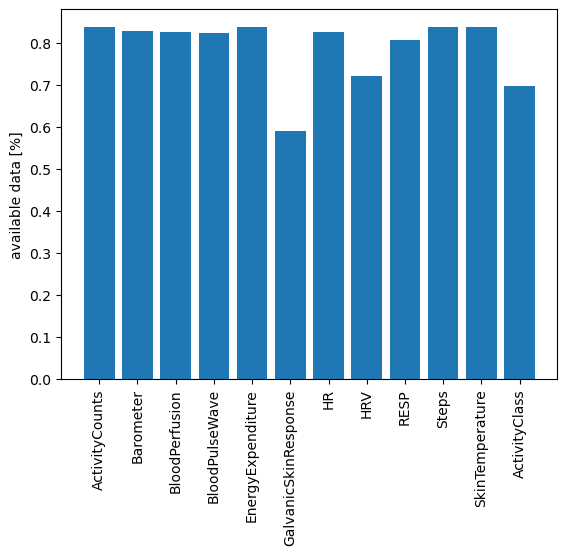

In [170]:
# missing data per variable
temp = missing_data_per_variable(data)

plt.bar(x=temp.keys(), height=temp.values())
plt.xticks(rotation=90)
plt.ylabel('available data [%]')

In [171]:
# discard variables from dataset (too much missing data)
if DISCARD_VARIABLES:
    to_discard = ['GalvanicSkinResponse', 'ActivityClass']

    data = data.drop(columns=to_discard)
    VARIABLES = [variable for variable in VARIABLES if variable not in to_discard]

Filter out days with sensors out all days

In [172]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        # if only missing data for full day -> discard day
        if np.sum(np.where(np.isnan(time_series), 0.0, 1.0)) == 0: # NaN -> 0, data -> 1
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (sensor out): {discarded_days} ({len(np.unique(discarded_days))})')
print(f'Days left: {len(data)}')

Discarded days (sensor out): [0, 1, 2, 3, 4, 5, 6, 7, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 47, 57, 59, 60, 61, 63, 68, 113, 114, 116, 117, 273, 380, 384, 389, 396, 398, 400, 405, 406, 408, 409] (42)
Days left: 368


Filter out days with > 80% missing data

In [173]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        # if only missing data for full day -> discard day
        if np.sum(np.where(np.isnan(time_series), 0.0, 1.0)) < 0.2 * length: # NaN -> 0, data -> 1
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (sensor out): {discarded_days} ({len(np.unique(discarded_days))})')
print(f'Days left: {len(data)}')

Discarded days (sensor out): [11, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 23, 27, 28, 29, 31, 34, 36, 37, 38, 39, 41, 42, 43, 44, 60, 65, 66, 67, 68, 73, 74, 74, 84, 84, 85, 85, 86, 86, 87, 89, 104, 107, 111, 112, 112, 187, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 321, 348, 349, 350, 355, 355, 356, 358, 359, 362, 363, 364, 365, 367] (50)
Days left: 318


Filter out days with data < 5min

In [174]:
discarded_days = []

days = range(data.shape[0])
for day in days:
    for variable in VARIABLES:
        time_series = get_time_series(data, variable, day)
        length = len(time_series)

        if length < 5:
            discarded_days.append(day)

data = data.drop(discarded_days)
data = data.reset_index(drop=True)
print(f'Discarded days (sensor out): {discarded_days} ({len(np.unique(discarded_days))})')
print(f'Days left: {len(data)}')

Discarded days (sensor out): [245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245, 245] (1)
Days left: 317


# Normalization

In [175]:
# normalize each variable considering all subjects
days, _ = data.shape
for variable in [var for var in VARIABLES if var != 'ActivityClass']:
    # get mean, variance of all subject data
    full_time_series = np.array([datapoint for day in range(days) for datapoint in get_time_series(data, variable, day)]).reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(full_time_series)

    # normalize accordingly
    for day in range(days):
        time_series = get_time_series(data, variable, day).reshape(-1, 1)
        data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)

C:\Users\jjung\AppData\Local\Temp\ipykernel_37232\707858869.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)
C:\Users\jjung\AppData\Local\Temp\ipykernel_37232\707858869.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[variable].iloc[day] = scaler.transform(time_series).reshape(-1)
C:\Users\jjung\AppData\Local\Temp\ipykernel_37232\707858869.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

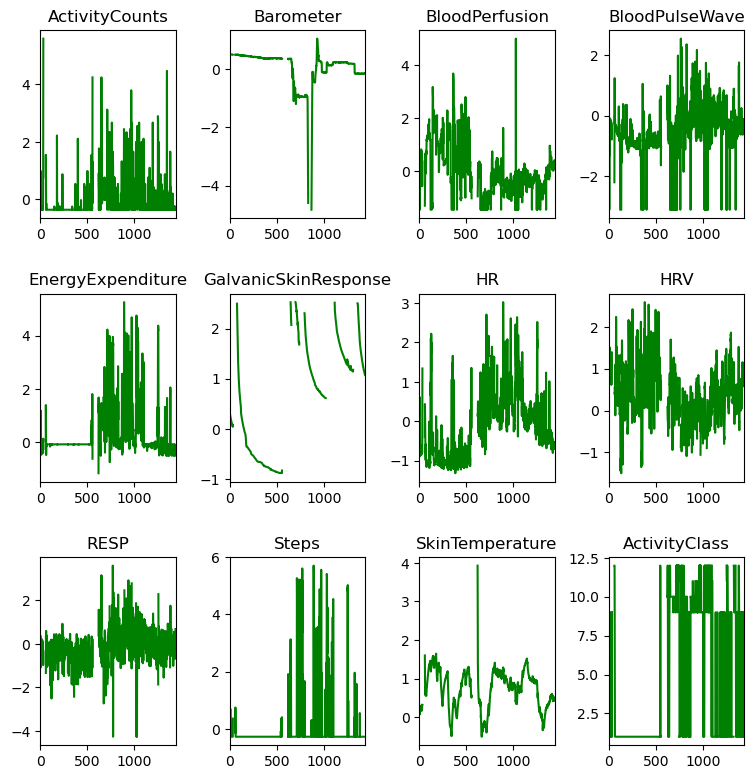

In [176]:
# visualize
plotter(np.random.choice(data.shape[0], 1, replace=False)[0], data)

# Imputation

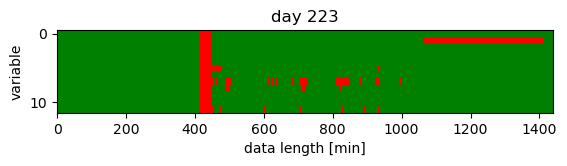

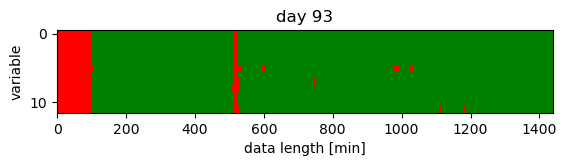

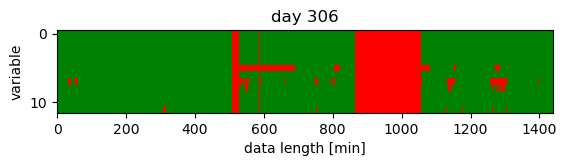

In [177]:
# visualize missing data (red: missing data, green: data)
N = 3
days = np.random.choice(data.shape[0], N, replace=False)
na_visualizer(days, data)

In [178]:
# imputation (everything)
MAX_FILL = 1440 # maximum imputation window (from both sides!)
METHOD = 'linear' # imputation method

data_imputed = imputer(data, max_fill=MAX_FILL, method=METHOD)

C:\Users\jjung\AppData\Local\Temp\ipykernel_37232\1122909922.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2[variable].iloc[day] = np.array(post_imputation.iloc[day])


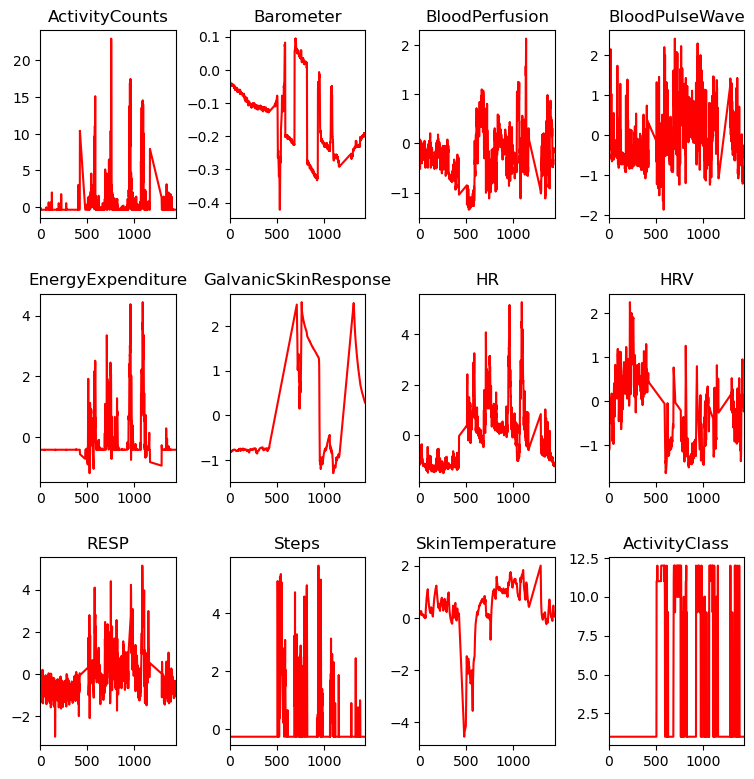

In [179]:
# visualize effect of imputation (red: fatigued, green: vigilant)
plotter(np.random.choice(data_imputed.shape[0], 1, replace=False)[0], data_imputed)

# Build feature vector

TZdiff not needed as additional feature?

In [180]:
query = '''
SELECT subjectID, GROUP_CONCAT(DISTINCT timezone)
FROM data
GROUP BY subjectID
HAVING COUNT(DISTINCT timezone) > 1;'''
sqldf(query)

,subjectID,GROUP_CONCAT(DISTINCT timezone)
0,24,"CET,CEST"
1,26,"CET,CEST"
2,27,"CET,CEST"


Statistical features

In [181]:
X = feature_vector(data_imputed) if USE_IMPUTATION else feature_vector(data)
y = label_vector(data_imputed) if USE_IMPUTATION else label_vector(data)

print(X.shape, y.shape)

(317, 284) (317, 2)


In [183]:
# check no NaNs in feature vector
for i, x in enumerate(X):
    assert np.sum(np.isnan(x)) == 0, f'Found NaN(s) in feature vector for day {i}'
print('All okay!')

All okay!


normalize features

In [184]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

array([[0.8765749 , 0.49570651, 0.64314399, ..., 0.        , 0.        ,
        0.        ],
       [1.00972907, 0.98551872, 0.64314399, ..., 0.        , 0.        ,
        0.        ],
       [0.92940271, 0.46942325, 0.75528835, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.9053044 , 0.63322026, 0.64314399, ..., 0.        , 0.        ,
        0.        ],
       [0.69082742, 0.56919712, 0.64314399, ..., 0.        , 0.        ,
        0.        ],
       [0.840045  , 0.53492467, 0.64314399, ..., 0.        , 0.        ,
        0.        ]])

# Random Forest

In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import warnings

In [189]:
# separate label prediction
y_phf, y_mf = y[:, 0], y[:, 1]

In [190]:
# CV ranges
n_trees = [3, 10, 50, 100, 300, 1000]
max_features = ['auto', 'sqrt', 'log2']
max_depths = [10, 30, 50, 100]
criterions = ['gini', 'entropy']
min_samples_splits = [2, 5, 10]

In [209]:
# nested CV (physical fatigue)
with warnings.catch_warnings():
    # ignore sklearn warning
    warnings.filterwarnings('ignore')

    # performance evaluation
    outer_cv = StratifiedKFold(n_splits=5)
    for train_outer_index, test_outer_index in tqdm(outer_cv.split(X, y_phf)):
        X_train, X_test = X[train_outer_index], X[test_outer_index]
        y_train, y_test = y_phf[train_outer_index], y_phf[test_outer_index]

        # hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=5)
        # we test every combination of parameters
        combinations = {}
        for n_tree in tqdm(n_trees):
            for max_feature in max_features:
                for max_depth in max_depths:
                    for criterion in criterions:
                        for min_sample_split in min_samples_splits:
                            rf = RandomForestClassifier(n_estimators=n_tree,
                                                        criterion=criterion,
                                                        max_depth=max_depth,
                                                        min_samples_split=min_sample_split,
                                                        max_features=max_feature)

                            scores = cross_val_score(rf, X_train, y_train, cv=inner_cv, scoring='f1_weighted')
                            combination = (n_tree, max_feature, max_depth, criterion, min_sample_split)
                            combinations[combination] = np.mean(scores)

0it [00:00, ?it/s]
 33%|███▎      | 2/6 [00:28<00:57, 14.28s/it]
0it [00:28, ?it/s]

KeyboardInterrupt



In [199]:
{(1, 'auto', 52.4): 1, (1, 'auto', 54.4): 2}

{(1, 'auto', 52.4): 1, (1, 'auto', 54.4): 2}

In [207]:
with warnings.catch_warnings():
    # ignore sklearn warning
    warnings.filterwarnings('ignore')

    inner_cv = StratifiedKFold(n_splits=5)
    # we test every combination of parameters
    combinations = {}
    for n_tree in tqdm(n_trees):
        for max_feature in max_features:
            for max_depth in max_depths:
                for criterion in criterions:
                    for min_sample_split in min_samples_splits:
                        rf = RandomForestClassifier(n_estimators=n_tree,
                                                    criterion=criterion,
                                                    max_depth=max_depth,
                                                    min_samples_split=min_sample_split,
                                                    max_features=max_feature)

                        scores = cross_val_score(rf, X, y_phf, cv=inner_cv, scoring='f1_weighted')
                        combination = (n_tree, max_feature, max_depth, criterion, min_sample_split)
                        combinations[combination] = np.mean(scores)

 17%|█▋        | 1/6 [00:11<00:55, 11.06s/it]

KeyboardInterrupt



In [200]:
t = list(combinations.values())

In [202]:
t

[0.6302658433828604,
 0.6384371338460366,
 0.6462475919944943,
 0.616098986948491,
 0.6454707583269789,
 0.6483581825147416,
 0.628320552076822,
 0.6475338631478983,
 0.6637537409904979,
 0.6378689505628818,
 0.6601357407133326,
 0.647008165511115,
 0.6351381130856192,
 0.6273466846385825,
 0.6365325310441393,
 0.6669213643784431,
 0.6334321810684729,
 0.6694850387105766,
 0.6390329595674956,
 0.6703421567494352,
 0.6411055143284772,
 0.7044086588175339,
 0.6543173501454539,
 0.6430073548430559,
 0.6364722308360543,
 0.5783245979274723,
 0.6043183061452533,
 0.6656253388025166,
 0.6359944094629016,
 0.7049532535625861,
 0.6424671302775333,
 0.7013865324925768,
 0.6496247698883376,
 0.6812045138079602,
 0.6579863908295331,
 0.6505266935971084,
 0.6395310247697412,
 0.6644954163924855,
 0.6001406236228946,
 0.6550648329383139,
 0.6224857118903586,
 0.628165490745376,
 0.6237110034686933,
 0.636253653019529,
 0.609473304796936,
 0.6777234547560066,
 0.6681015446148372,
 0.6229036551200349

In [203]:
len(t)

432

In [204]:
np.max(t)

0.7104943854965631

In [ ]:
# nested CV (mental fatigue)


In [168]:
from sklearn.ensemble import RandomForestClassifier
temp = copy.deepcopy(X)
temp[np.isnan(temp)] = 0
rf = RandomForestClassifier(n_estimators=100,
                            criterion="gini",
                            max_depth=10,
                            min_samples_split=2,
                            max_features="sqrt",
                            verbose=0)
rf.fit(temp, y)

RandomForestClassifier(max_depth=10)

In [159]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,
                       criterion="gini",
                       max_depth=10,
                       min_samples_split=2,
                       max_features="sqrt",
                       verbose=1)
rf.fit(X, y)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [175]:
y[:, 0]

array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [183]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
temp = copy.deepcopy(X)
temp[np.isnan(temp)] = 0
rf = RandomForestClassifier(n_estimators=100,
                            criterion="gini",
                            max_depth=10,
                            min_samples_split=2,
                            max_features="sqrt",
                            verbose=0)

print(cross_val_score(rf, temp, y[:, 0], cv=10, scoring='f1_weighted'))
print(cross_val_score(rf, temp, y[:, 0], cv=10, scoring=['f1_weighted', 'f1']))

[0.60137672 0.83031674 0.45652174 0.5        0.76666667 0.71010101
 0.89819005 0.72212078 0.67565982 0.67565982]


ValueError: For evaluating multiple scores, use sklearn.model_selection.cross_validate instead. ['f1_weighted', 'f1'] was passed.

In [195]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

scores = cross_validate(RandomForestClassifier(n_estimators=300,
                                               criterion="gini",
                                               max_depth=10,
                                               min_samples_split=2,
                                               max_features="sqrt",
                                               verbose=0),
                        StandardScaler().fit_transform(temp),
                        y[:, 0],
                        cv=StratifiedKFold(n_splits=5),
                        scoring=('f1_weighted', 'recall_weighted', 'precision_weighted'))

print(f"f1: {np.mean(scores['test_f1_weighted'])}, recall: {np.mean(scores['test_recall_weighted'])}, prec.:{np.mean(scores['test_precision_weighted'])}")

f1: 0.6154253493502324, recall: 0.6571924603174603, prec.:0.6732423030202739


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [193]:
scores = cross_validate(rf, StandardScaler().fit_transform(temp), y[:, 0], cv=5, scoring=('f1_weighted', 'recall_weighted', 'precision_weighted'))
print(f"f1: {np.mean(scores['test_f1_weighted'])}, recall: {np.mean(scores['test_recall_weighted'])}, prec.:{np.mean(scores['test_precision_weighted'])}")

f1: 0.6180909634994058, recall: 0.6509424603174603, prec.:0.6725459645784652


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
scores = cross_validate(rf, temp, y[:, 0], cv=5, scoring=('f1_weighted', 'recall_weighted', 'precision_weighted'))
print(f"f1: {np.mean(scores['test_f1_weighted'])}, recall: {np.mean(scores['test_recall_weighted'])}, prec.:{np.mean(scores['test_precision_weighted'])}")

f1: 0.6030616948594476, recall: 0.6446924603174603, prec.:0.6839932528958629


accuracy: 0.734375
balanced accuracy: 0.5277777777777778
f1 (weighted): 0.6362566393046837
recall (weighted): 0.734375
precision (weighted): 0.8060515873015873


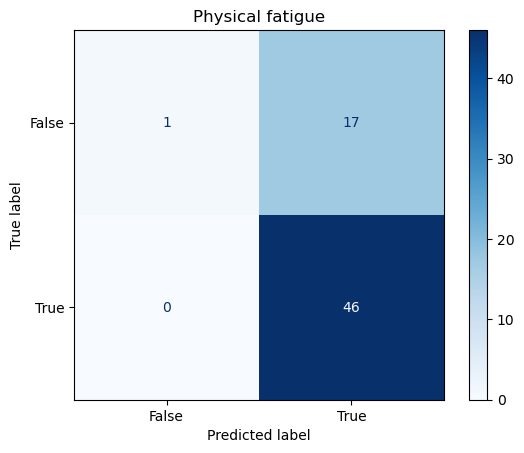

In [212]:
# train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(temp), y[:, 0], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100,
                            criterion="gini",
                            max_depth=10,
                            min_samples_split=2,
                            max_features="sqrt",
                            verbose=0)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

accuracy: 0.734375
balanced accuracy: 0.5615942028985508
f1 (weighted): 0.6757505175983436
recall (weighted): 0.734375
precision (weighted): 0.7047669491525423


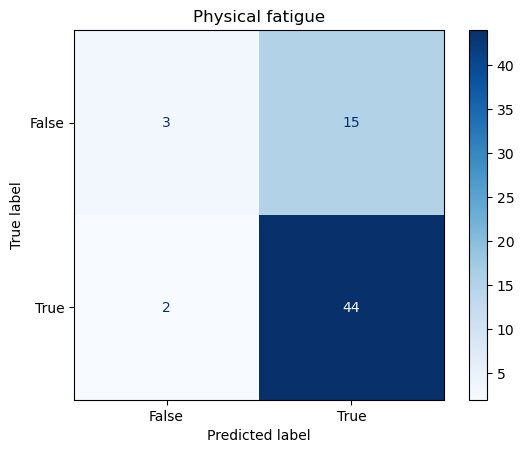

In [197]:
# train test split - without normalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(temp, y[:, 0], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100,
                            criterion="gini",
                            max_depth=10,
                            min_samples_split=2,
                            max_features="sqrt",
                            verbose=0)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

In [198]:
temp.shape

(317, 284)

In [200]:
len(data_imputed)

317

In [202]:
np.unique(data['subjectID'])

array([ 3,  4,  5,  7,  9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23,
       24, 25, 26, 27], dtype=int64)

accuracy: 0.75
balanced accuracy: 0.5555555555555556
f1 (weighted): 0.6685185185185185
recall (weighted): 0.75
precision (weighted): 0.8145161290322581


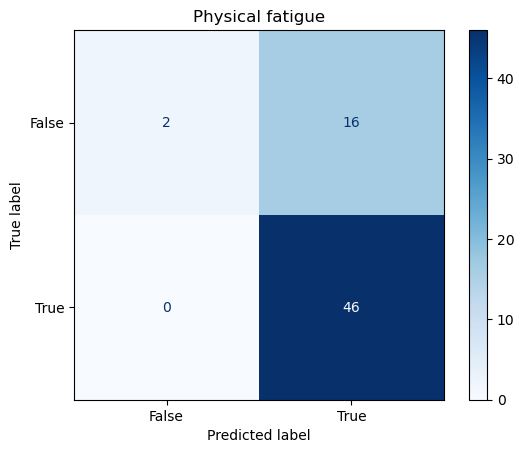

In [208]:
# train test split - without normalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

for subject in np.unique(data['subjectID']):
    indices = np.arange(len(data))[data['subjectID'] == subject]
    scaler = StandardScaler()
    scaler.fit(temp[indices, :])
    temp[indices, :] = scaler.transform(temp[indices, :])

X_train, X_test, y_train, y_test = train_test_split(temp, y[:, 0], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100,
                            criterion="gini",
                            max_depth=10,
                            min_samples_split=2,
                            max_features="sqrt",
                            verbose=0)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)

accuracy = accuracy_score(y_pred=y_test_pred, y_true=y_test)
balanced_accuracy = balanced_accuracy_score(y_pred=y_test_pred, y_true=y_test)
f1_weighted = f1_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
recall_weighted = recall_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
precision_weighted = precision_score(y_pred=y_test_pred, y_true=y_test, average='weighted')
confusion = confusion_matrix(y_pred=y_test_pred, y_true=y_test)
ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True]).plot(cmap=plt.cm.Blues)
plt.title('Physical fatigue')

print(f'accuracy: {accuracy}\n'
      f'balanced accuracy: {balanced_accuracy}\n'
      f'f1 (weighted): {f1_weighted}\n'
      f'recall (weighted): {recall_weighted}\n'
      f'precision (weighted): {precision_weighted}')

# We normalized (Z-score) features only in the training set and used the resulting mean and std to normalize the test set.

# To mitigate for unbalanced labels, we added class weights (ratio between number of samples from each class and the total number of samples in the training set) to the loss function of the prediction models

# Furthermore, we optimized all models based on weighted F1 score.

# Export data

In [101]:
# file path to data folder
output_path = './Output'

In [102]:
# save all vectors as separate files for data generator (WARNING: takes a lot of time)
with tqdm(total=len(X)) as pbar:
    for i, (x, y_) in enumerate(zip(X, y)):
        np.save(output_path + f'/feature_vector_RF{i}', x)
        np.save(output_path + f'/labels_RF{i}', y_)
        pbar.update(1)

100%|██████████| 3097/3097 [01:40<00:00, 30.80it/s] 


In [105]:
# save metadata
with open(output_path + '/metadata.txt','w') as dat:
    dat.write(str(metadata))